In [28]:
import matplotlib
import matplotlib
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import confusion_matrix
import warnings #to remove the warnings
warnings.filterwarnings('ignore')

def generateNewFeatureValMultiple(df, col, numberOfBins, numPatients):
    hist, bins = np.histogram(df[col], bins=numberOfBins)
    bin_midpoints = bins[:-1] + np.diff(bins)/2
    cdf = np.cumsum(hist)
    cdf = cdf / cdf[-1]
    values = np.random.rand(numPatients)
    value_bins = np.searchsorted(cdf, values)
    random_from_cdf = bin_midpoints[value_bins]
    return list(random_from_cdf)   



In [29]:
raw_df = pd.read_csv('../../Wisconsin_Database/breast-cancer-wisconsin.data', header=None)
cols = ['ID', 'Thickness', 'SizeUniformity', 'ShapeUniformity', 'Adhesion', 'Size', 'BareNuclei', 'Bland Chromatin', 'Nucleoli', 'Mitoses', 'Diagnosis']
raw_df.columns = cols
raw_df['Diagnosis'] = raw_df['Diagnosis'].map(
                   {2:0,4:1})

temp = []
for index, row in raw_df.iterrows():
    if '?' not in row.values:
        temp.append(row)
        
df = pd.DataFrame(np.array(temp), columns=cols)
df['BareNuclei'] = df['BareNuclei'].astype(np.int)
print(df.shape)
print(df)


(683, 11)
          ID Thickness SizeUniformity ShapeUniformity Adhesion Size  \
0    1000025         5              1               1        1    2   
1    1002945         5              4               4        5    7   
2    1015425         3              1               1        1    2   
3    1016277         6              8               8        1    3   
4    1017023         4              1               1        3    2   
..       ...       ...            ...             ...      ...  ...   
678   776715         3              1               1        1    3   
679   841769         2              1               1        1    2   
680   888820         5             10              10        3    7   
681   897471         4              8               6        4    3   
682   897471         4              8               8        5    4   

     BareNuclei Bland Chromatin Nucleoli Mitoses Diagnosis  
0             1               3        1       1         0  
1            10

In [30]:
augmentedKnnScores = []
augmentedNaiveBaysScores = []
augmentedLogisticRegressionScores = []
augmentedSvmRegressionScores = []
augmentedDecisionTreeRegressionScores = []
for i in range(10):
    X = df[cols[1:-1]]
    y = df[cols[-1]]

    SEED = 42 + i
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=SEED)
    #print('X Train: {}'.format(X_train.shape))
    #print('y_train: {}'.format(y_train.shape))
    trainingSet = X_train.copy()
    trainingSet['Diagnosis'] = y_train
    arr2D = trainingSet.to_numpy()
    columnIndex = -1
    sortedArr = arr2D[arr2D[:,columnIndex].argsort()]
    numZeros = list(sortedArr[:, columnIndex]).count(0)
    benignDF, malignantDF = pd.DataFrame(sortedArr[0:numZeros]), pd.DataFrame(sortedArr[numZeros:])
    #print('benignDF: {}'.format(benignDF.shape))
    #print('malignantDF: {}'.format(malignantDF.shape))
    benignDF.columns = trainingSet.columns
    malignantDF.columns = trainingSet.columns
    benignPatients = []
    for col in benignDF.columns:
        benignPatients.append(generateNewFeatureValMultiple(benignDF, col, 25, benignDF.shape[0]))
    beningPatients = np.array(benignPatients).T
    malignangPatients = []
    for col in malignantDF.columns:
        malignangPatients.append(generateNewFeatureValMultiple(malignantDF, col, 25, malignantDF.shape[0]))
    malignangPatients = np.array(malignangPatients).T
    #print('benignPatients: {}'.format(np.array(beningPatients).shape))
    #print('malignantPatients: {}'.format(np.array(malignangPatients).shape))
    jointArray = np.vstack((beningPatients,malignangPatients))
    finalDataset = pd.DataFrame(jointArray, columns = benignDF.columns)
    X_train = finalDataset[finalDataset.columns[:-1]]
    y_train = finalDataset[finalDataset.columns[-1]]
    #print('Augmented X Train: {}'.format(X_train.shape))
    #print('Augmented y_train: {}'.format(y_train.shape))
    scaler = StandardScaler()
    scaler.fit(X_train)

    col_names=df.columns[2:]
    scaled_df = pd.DataFrame(X_train, columns=col_names)
    scaled_df.describe().T



    ''' KNN '''

    
    error = []
    score_vals = []
    for j in range(1, 20):
        knn = KNeighborsRegressor(n_neighbors=j)
        knn.fit(X_train, y_train)
        pred_i = knn.predict(X_test).round(decimals=0)
        mae = mean_absolute_error(y_test, pred_i)
        error.append(mae)
        score_vals.append(knn.score(X_test, y_test))
        y_pred = knn.predict(X_test).round(decimals=0)
        y_pred = y_pred == 1
        performanceAccuracy = sum(y_pred == y_test)/len(y_test)
    bestIndex = score_vals.index(max(score_vals)) + 1  #Adds one because it starts with 1 neighbor not 0

    regressor = KNeighborsRegressor(n_neighbors=bestIndex)
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test).round(decimals=0)
    y_pred = y_pred == 1
    #print('Iteration {}: '.format(i))
    performanceAccuracy = sum(y_pred == y_test)/len(y_test)
    augmentedKnnScores.append(performanceAccuracy)

    '''Naive Bayes'''

    nb = GaussianNB()
    nb.fit(X_train, y_train)
    y_pred = (nb.predict(X_test))
    performanceAccuracy = sum(y_pred == y_test)/len(y_test)
    augmentedNaiveBaysScores.append(performanceAccuracy)

    '''Logistic Regression'''

    modelLogistic = LogisticRegression()
    modelLogistic.fit(X_train,y_train)
    y_pred = modelLogistic.predict(X_test)
    performanceAccuracy = sum(y_pred == y_test)/len(y_test)
    augmentedLogisticRegressionScores.append(performanceAccuracy)

    '''SVM'''

    svclassifier = SVC(kernel='linear')
    svclassifier.fit(X_train, y_train)
    y_pred = svclassifier.predict(X_test)
    performanceAccuracy = sum(y_pred == y_test)/len(y_test)
    augmentedSvmRegressionScores.append(performanceAccuracy)
    
    '''Decision Tree'''

    clf = DecisionTreeClassifier()
    clf = clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    performanceAccuracy = sum(y_pred == y_test)/len(y_test)
    augmentedDecisionTreeRegressionScores.append(performanceAccuracy)
    print('Iteration: {}'.format(i))




print('KNN - Min: {}, Max: {}, Avg: {}'.format(min(augmentedKnnScores), max(augmentedKnnScores), sum(augmentedKnnScores)/len(augmentedKnnScores)))
#print('   Best Seed: {}'.format(42 + knnScores.index(max(knnScores))))
print('NB  - Min: {}, Max: {}, Avg: {}'.format(min(augmentedNaiveBaysScores), max(augmentedNaiveBaysScores), sum(augmentedNaiveBaysScores)/len(augmentedNaiveBaysScores)))
#print('   Best Seed: {}'.format(42 + naiveBaysScores.index(max(naiveBaysScores))))
print('LR  - Min: {}, Max: {}, Avg: {}'.format(min(augmentedLogisticRegressionScores), max(augmentedLogisticRegressionScores), sum(augmentedLogisticRegressionScores)/len(augmentedLogisticRegressionScores)))
#print('   Best Seed: {}'.format(42 + logisticRegressionScores.index(max(logisticRegressionScores))))
print('SVM - Min: {}, Max: {}, Avg: {}'.format(min(augmentedSvmRegressionScores), max(augmentedSvmRegressionScores), sum(augmentedSvmRegressionScores)/len(augmentedSvmRegressionScores)))
#print('   Best Seed: {}'.format(42 + svmRegressionScores.index(max(svmRegressionScores))))
print('DT  - Min: {}, Max: {}, Avg: {}'.format(min(augmentedDecisionTreeRegressionScores), max(augmentedDecisionTreeRegressionScores), sum(augmentedDecisionTreeRegressionScores)/len(augmentedDecisionTreeRegressionScores)))
#print('   Best Seed: {}'.format(42 + decisionTreeRegressionScores.index(max(decisionTreeRegressionScores))))


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
KNN - Min: 0.9343065693430657, Max: 0.9854014598540146, Avg: 0.9635036496350367
NB  - Min: 0.9343065693430657, Max: 0.9781021897810219, Avg: 0.959124087591241
LR  - Min: 0.948905109489051, Max: 0.9854014598540146, Avg: 0.9715328467153286
SVM - Min: 0.9562043795620438, Max: 0.9781021897810219, Avg: 0.9686131386861314
DT  - Min: 0.7518248175182481, Max: 0.8394160583941606, Avg: 0.7883211678832117


In [31]:
knnScores = []
naiveBaysScores = []
logisticRegressionScores = []
svmRegressionScores = []
decisionTreeRegressionScores = []
for i in range(10):
    X = df[cols[1:-1]]
    y = df[cols[-1]]
    y=y.astype('int')

    SEED = 42 + i
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=SEED)
    scaler = StandardScaler()
    scaler.fit(X_train)

    col_names=df.columns[2:]
    scaled_df = pd.DataFrame(X_train, columns=col_names)
    scaled_df.describe().T



    ''' KNN '''
    
    error = []
    score_vals = []
    for j in range(1, 20):
        knn = KNeighborsRegressor(n_neighbors=j)
        knn.fit(X_train, y_train)
        pred_i = knn.predict(X_test)
        mae = mean_absolute_error(y_test, pred_i)
        error.append(mae)
        score_vals.append(knn.score(X_test, y_test))
        y_pred = knn.predict(X_test)
        y_pred = y_pred == 1
        performanceAccuracy = sum(y_pred == y_test)/len(y_test)
    bestIndex = score_vals.index(max(score_vals)) + 1  #Adds one because it starts with 1 neighbor not 0

    regressor = KNeighborsRegressor(n_neighbors=bestIndex)
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    y_pred = y_pred == 1
    #print('Iteration {}: '.format(i))
    performanceAccuracy = sum(y_pred == y_test)/len(y_test)
    knnScores.append(performanceAccuracy)

    '''Naive Bayes'''
    nb = GaussianNB()
    nb.fit(X_train, y_train)
    y_pred = (nb.predict(X_test))
    performanceAccuracy = sum(y_pred == y_test)/len(y_test)
    naiveBaysScores.append(performanceAccuracy)

    '''Logistic Regression'''

    modelLogistic = LogisticRegression()
    modelLogistic.fit(X_train,y_train)
    y_pred = modelLogistic.predict(X_test)
    performanceAccuracy = sum(y_pred == y_test)/len(y_test)
    logisticRegressionScores.append(performanceAccuracy)

    '''SVM'''

    svclassifier = SVC(kernel='linear')
    svclassifier.fit(X_train, y_train)
    y_pred = svclassifier.predict(X_test)
    performanceAccuracy = sum(y_pred == y_test)/len(y_test)
    svmRegressionScores.append(performanceAccuracy)
    
    '''Decision Tree'''

    clf = DecisionTreeClassifier()
    clf = clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    performanceAccuracy = sum(y_pred == y_test)/len(y_test)
    decisionTreeRegressionScores.append(performanceAccuracy)
    print('Iteration: {}'.format(i))




print('KNN - Min: {}, Max: {}, Avg: {}'.format(min(knnScores), max(knnScores), sum(knnScores)/len(knnScores)))
#print('   Best Seed: {}'.format(42 + knnScores.index(max(knnScores))))
print('NB  - Min: {}, Max: {}, Avg: {}'.format(min(naiveBaysScores), max(naiveBaysScores), sum(naiveBaysScores)/len(naiveBaysScores)))
#print('   Best Seed: {}'.format(42 + naiveBaysScores.index(max(naiveBaysScores))))
print('LR  - Min: {}, Max: {}, Avg: {}'.format(min(logisticRegressionScores), max(logisticRegressionScores), sum(logisticRegressionScores)/len(logisticRegressionScores)))
#print('   Best Seed: {}'.format(42 + logisticRegressionScores.index(max(logisticRegressionScores))))
print('SVM - Min: {}, Max: {}, Avg: {}'.format(min(svmRegressionScores), max(svmRegressionScores), sum(svmRegressionScores)/len(svmRegressionScores)))
#print('   Best Seed: {}'.format(42 + svmRegressionScores.index(max(svmRegressionScores))))
print('DT  - Min: {}, Max: {}, Avg: {}'.format(min(decisionTreeRegressionScores), max(decisionTreeRegressionScores), sum(decisionTreeRegressionScores)/len(decisionTreeRegressionScores)))
#print('   Best Seed: {}'.format(42 + decisionTreeRegressionScores.index(max(decisionTreeRegressionScores))))


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
KNN - Min: 0.8102189781021898, Max: 0.9416058394160584, Avg: 0.8905109489051094
NB  - Min: 0.9416058394160584, Max: 0.9781021897810219, Avg: 0.9635036496350364
LR  - Min: 0.9562043795620438, Max: 0.9854014598540146, Avg: 0.9678832116788321
SVM - Min: 0.9562043795620438, Max: 0.9854014598540146, Avg: 0.97007299270073
DT  - Min: 0.8832116788321168, Max: 0.9635036496350365, Avg: 0.9364963503649634


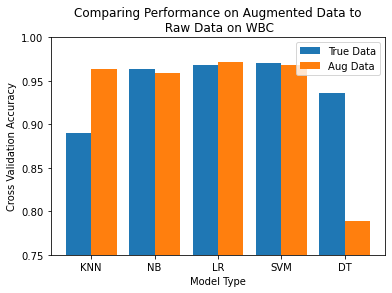

In [32]:
import matplotlib.pyplot as plt 
  
X = ['KNN','NB','LR','SVM', 'DT']

aug = [np.mean(augmentedKnnScores), np.mean(augmentedNaiveBaysScores), np.mean(augmentedLogisticRegressionScores),
        np.mean(augmentedSvmRegressionScores), np.mean(augmentedDecisionTreeRegressionScores)]
reg = [np.mean(knnScores), np.mean(naiveBaysScores), np.mean(logisticRegressionScores),
        np.mean(svmRegressionScores), np.mean(decisionTreeRegressionScores)]

Ygirls = [10,20,20,40]
Zboys = [20,30,25,30]
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, reg, 0.4, label = 'True Data')
plt.bar(X_axis + 0.2, aug, 0.4, label = 'Aug Data')
  
plt.xticks(X_axis, X)
plt.xlabel("Model Type")
plt.ylabel("Cross Validation Accuracy")
plt.ylim(0.75,1)
plt.title("Comparing Performance on Augmented Data to\n Raw Data on WBC")
plt.legend()
plt.show()